In [130]:
import numpy as np
import json
import warnings
import operator

import h5py
from keras.models import model_from_json
from keras import backend as K
from keras.utils import get_custom_objects

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

warnings.filterwarnings("ignore")

base_path = 'data/'

all_approaches_path = ['deep_network_bc/', 'cnn_bc/', 'rnn_bc/', 'rnn_custom_loss/']

titles = ['(a) Deep network', '(b) CNN', '(c) RNN', '(d) RNN with weighted loss']

font = {'family': 'serif', 'size': 14}

alpha_fade = 0.1
fig_size = (12, 12)

plt.rc('font', **font)

size_title = 18
size_label = 16
runs = 10

def read_file(path):
    with open(path) as f:
        data = f.read()
        data = data.split("\n")
        data.remove('')
        data = list(map(float, data))
        return data


def extract_precision(precision_path):

    top1_compatible_precision = list()
    top2_compatible_precision = list()
    top3_compatible_precision = list()
    with open(precision_path) as f:
        data = f.read()
        data = data.split("\n")
        data.remove('')
        
        for row in data:
            row = row.split('\n')
            row = row[0].split(' ')
            row = list(map(float, row))
            top1_compatible_precision.append(row[0])
            top2_compatible_precision.append(row[1])
            top3_compatible_precision.append(row[2])
    return top1_compatible_precision, top2_compatible_precision, top3_compatible_precision


def compute_fill_between(a_list):
    y1 = list()
    y2 = list()
    a_list = np.array(a_list, dtype=float)
    n_cols = a_list.shape[1]
    for i in range(0, n_cols):
        pos = a_list[:, i]
        std = np.std(pos)
        y1.append(std)
        y2.append(std)
    return y1, y2

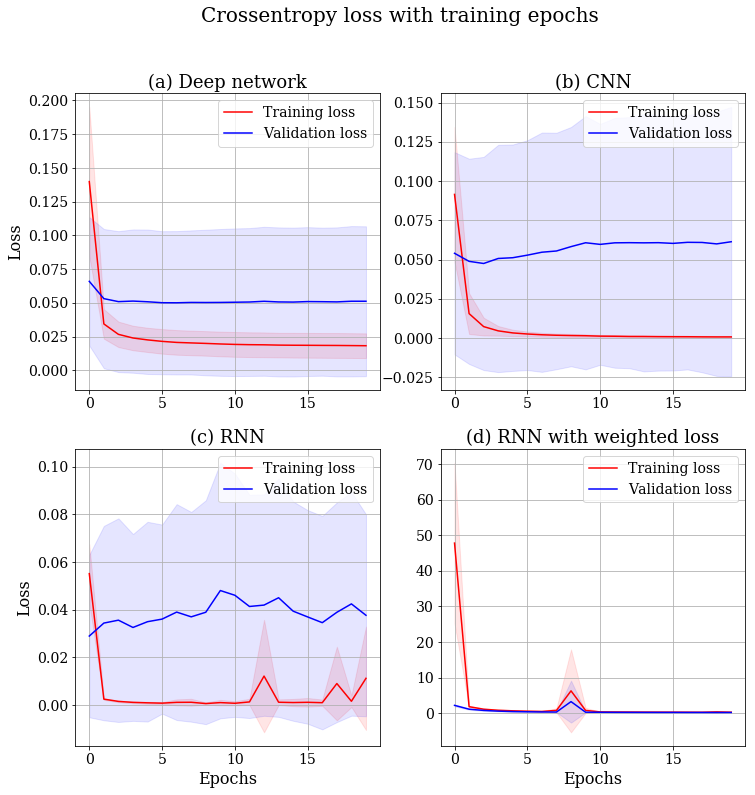

In [131]:
def plot_loss(ax, x_val1, loss_tr_y1, loss_tr_y2, x_val2, loss_te_y1, loss_te_y2, title, xlabel, ylabel, leg):
    x_pos = np.arange(len(x_val1))
    ax.plot(x_pos, x_val1, 'r')
    ax.plot(x_pos, x_val2, 'b')
    ax.set_title(title, size=size_title)
    ax.fill_between(x_pos, loss_tr_y1, loss_tr_y2, color = 'r', alpha = alpha_fade)
    ax.fill_between(x_pos, loss_te_y1, loss_te_y2, color = 'b', alpha = alpha_fade)
    ax.legend(leg)
    ax.grid(True)


def assemble_loss():
    fig = plt.figure(figsize=fig_size)
    fig.suptitle('Crossentropy loss with training epochs', size=size_title + 2)
    gs = gridspec.GridSpec(2,2)
    for idx, approach in enumerate(all_approaches_path):
        if idx == 0:
            ax = plt.subplot(gs[0,0])
            ax.set_ylabel("Loss", size=size_label)
        elif idx == 1:
            ax = plt.subplot(gs[0,1])
        elif idx == 2:
            ax = plt.subplot(gs[1,0])
            ax.set_xlabel("Epochs", size=size_label)
            ax.set_ylabel("Loss", size=size_label)
        else:
            ax = plt.subplot(gs[1,1])
            ax.set_xlabel("Epochs", size=size_label)
            
        train_loss = list()
        test_loss = list()

        for i in range(1, runs+1):
            path = base_path + approach + 'run' + str(i) + '/'
            tr_loss_path = path + 'train_loss.txt'
            val_loss_path = path + 'validation_loss.txt'
            try:
                tr_loss = read_file(tr_loss_path)
                train_loss.append(tr_loss)
                te_loss = read_file(val_loss_path)
                test_loss.append(te_loss)
            except Exception:
                continue
        loss_tr_y1, loss_tr_y2 = compute_fill_between(train_loss)
        loss_te_y1, loss_te_y2 = compute_fill_between(test_loss)

        mean_tr_loss = np.mean(train_loss, axis=0)
        mean_te_loss = np.mean(test_loss, axis=0)
        plt_title = titles[idx]
        plot_loss(ax, mean_tr_loss, mean_tr_loss - loss_tr_y1, mean_tr_loss + loss_tr_y2, \
            mean_te_loss, mean_te_loss - loss_te_y1, mean_te_loss + loss_te_y2, \
            plt_title + "", "Epochs", "Loss",  ['Training loss', 'Validation loss'])
assemble_loss()

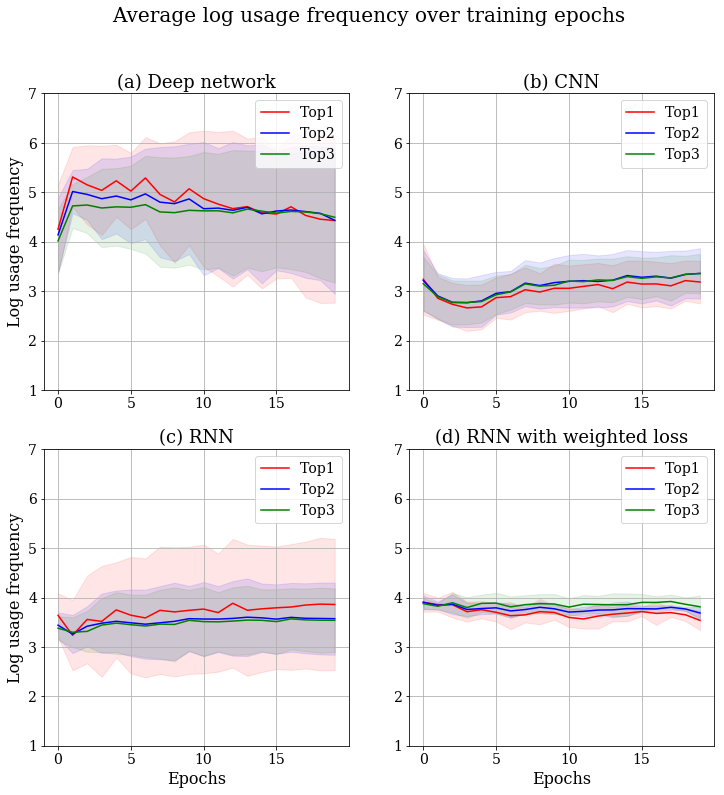

In [132]:
usage_ylim = (1.0, 7.0)

def plot_usage(ax, x_val1, y1_top1, y2_top1, x_val2, y1_top2, y2_top2, x_val3, y1_top3, y2_top3, title, xlabel, ylabel, leg):
    x_pos = np.arange(len(x_val1))
    ax.plot(x_pos, x_val1, 'r')
    ax.plot(x_pos, x_val2, 'b')
    ax.plot(x_pos, x_val3, 'g')
    ax.set_title(title, size=size_title)
    ax.fill_between(x_pos, y1_top1, y2_top1, color = 'r', alpha = alpha_fade)
    ax.fill_between(x_pos, y1_top2, y2_top2, color = 'b', alpha = alpha_fade)
    ax.fill_between(x_pos, y1_top3, y2_top3, color = 'g', alpha = alpha_fade)
    ax.legend(leg)
    ax.set_ylim(usage_ylim)
    ax.grid(True)

def assemble_usage():
    fig = plt.figure(figsize=fig_size)
    fig.suptitle('Average log usage frequency over training epochs', size=size_title + 2)
    gs = gridspec.GridSpec(2, 2)
    for idx, approach in enumerate(all_approaches_path):
        if idx == 0:
            ax = plt.subplot(gs[0,0])
            ax.set_ylabel("Log usage frequency", size=size_label)
        elif idx == 1:
            ax = plt.subplot(gs[0,1])
        elif idx == 2:
            ax = plt.subplot(gs[1,0])
            ax.set_xlabel("Epochs", size=size_label)
            ax.set_ylabel("Log usage frequency", size=size_label)
        else:
            ax = plt.subplot(gs[1,1])
            ax.set_xlabel("Epochs", size=size_label)
        usage_top1 = list()
        usage_top2 = list()
        usage_top3 = list()

        for i in range(1, runs+1):
            path = base_path + approach + 'run' + str(i) + '/'
            usage_path = path + 'usage_weights.txt'
            try:
                top1_p, top2_p, top3_p = extract_precision(usage_path)
                usage_top1.append(top1_p)
                usage_top2.append(top2_p)
                usage_top3.append(top3_p)
            except Exception:
                continue
        mean_top1_usage = np.mean(usage_top1, axis=0)
        mean_top2_usage = np.mean(usage_top2, axis=0)
        mean_top3_usage = np.mean(usage_top3, axis=0)

        y1_top1, y2_top1 = compute_fill_between(usage_top1)
        y1_top2, y2_top2 = compute_fill_between(usage_top2)
        y1_top3, y2_top3 = compute_fill_between(usage_top3)
        plt_title = titles[idx]

        plot_usage(ax, mean_top1_usage, mean_top1_usage - y1_top1, mean_top1_usage + y2_top1, \
            mean_top2_usage, mean_top2_usage - y1_top2, mean_top2_usage + y2_top2, \
            mean_top3_usage, mean_top3_usage - y1_top3, mean_top3_usage + y2_top3, \
            plt_title, "Epochs", "Log usage", ['Top1', 'Top2', 'Top3'])

assemble_usage()

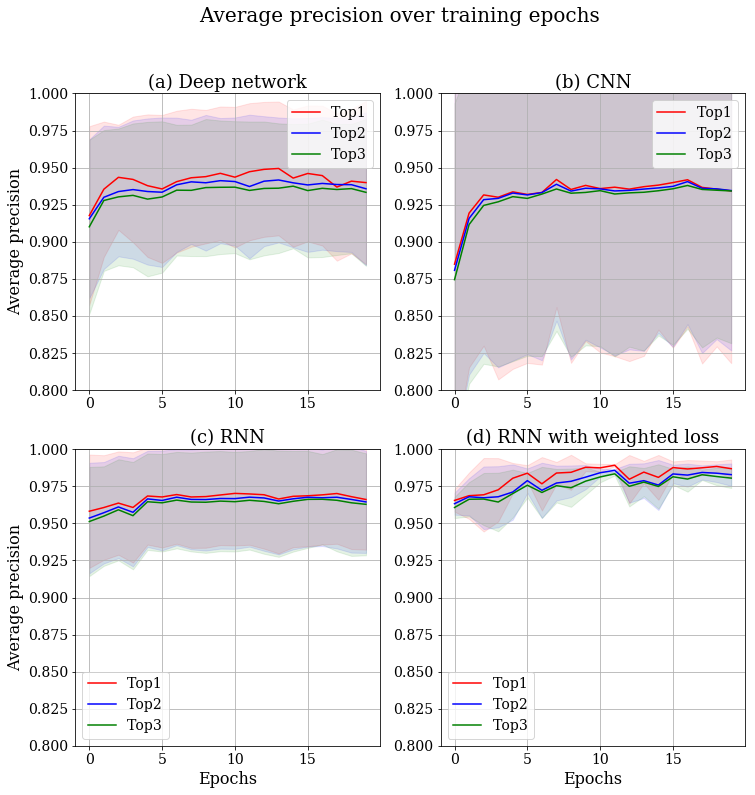

In [135]:
precision_ylim = (0.8, 1.0)

def plot_accuracy(ax, x_val1, y1_top1, y2_top1, x_val2, y1_top2, y2_top2, x_val3, y1_top3, y2_top3, title, xlabel, ylabel, leg):
    x_pos = np.arange(len(x_val1))
    ax.plot(x_pos, x_val1, 'r')
    ax.plot(x_pos, x_val2, 'b')
    ax.plot(x_pos, x_val3, 'g')

    ax.set_title(title, size=size_title)
    ax.fill_between(x_pos, y1_top1, y2_top1, color = 'r', alpha = alpha_fade)
    ax.fill_between(x_pos, y1_top2, y2_top2, color = 'b', alpha = alpha_fade)
    ax.fill_between(x_pos, y1_top3, y2_top3, color = 'g', alpha = alpha_fade)
    ax.legend(leg)
    ax.set_ylim(precision_ylim)
    plt.grid(True)

def assemble_accuracy():
    fig = plt.figure(figsize=fig_size)
    fig.suptitle('Average precision over training epochs', size=size_title + 2)
    gs = gridspec.GridSpec(2,2)
    for idx, approach in enumerate(all_approaches_path):
        if idx == 0:
            ax = plt.subplot(gs[0,0])
            ax.set_ylabel("Average precision", size=size_label)
        elif idx == 1:
            ax = plt.subplot(gs[0,1])
            
        elif idx == 2:
            ax = plt.subplot(gs[1,0])
            ax.set_xlabel("Epochs", size=size_label)
            ax.set_ylabel("Average precision", size=size_label)
        else:
            ax = plt.subplot(gs[1,1])
            ax.set_xlabel("Epochs", size=size_label)

        precision_acc_top1 = list()
        precision_acc_top2 = list()
        precision_acc_top3 = list()

        for i in range(1, runs+1):
            path = base_path + approach + 'run' + str(i) + '/'
            precision_path = path + 'precision.txt'
    
            try:
                top1_p, top2_p, top3_p = extract_precision(precision_path)
                precision_acc_top1.append(top1_p)
                precision_acc_top2.append(top2_p)
                precision_acc_top3.append(top3_p)
            except Exception:
                continue

        mean_top1_acc = np.mean(precision_acc_top1, axis=0)
        mean_top2_acc = np.mean(precision_acc_top2, axis=0)
        mean_top3_acc = np.mean(precision_acc_top3, axis=0)

        y1_top1, y2_top1 = compute_fill_between(precision_acc_top1)
        y1_top2, y2_top2 = compute_fill_between(precision_acc_top2)
        y1_top3, y2_top3 = compute_fill_between(precision_acc_top3)
        plt_title = titles[idx]
        plot_accuracy(ax,mean_top1_acc, mean_top1_acc - y1_top1, mean_top1_acc + y2_top1, \
                      mean_top2_acc, mean_top2_acc - y1_top2, mean_top2_acc + y2_top2, \
                      mean_top3_acc, mean_top3_acc - y1_top3, mean_top3_acc + y2_top3, \
                      plt_title, "Epochs", "Precision", ['Top1', 'Top2', 'Top3'])
assemble_accuracy()